In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [20]:
import pandas as pd

# Specify the full file path
file_path = r"C:\Users\sduvvada\Downloads\GenContingencyAllGen.xlsx" 
df = pd.read_excel(file_path)

print(df.head())


   Run #  Pm02  Pm03  factor5  factor6  factor8  f_nadir(Hz)  RoCof(Hz/s)  \
0      1   143    65      0.9      0.9      0.9    59.321788    -0.922567   
1      2   148    65      0.9      0.9      0.9    59.360917    -0.876443   
2      3   153    65      0.9      0.9      0.9    59.400090    -0.827881   
3      4   158    65      0.9      0.9      0.9    59.439296    -0.768516   
4      5   163    65      0.9      0.9      0.9    59.478582    -0.718783   

   InputPg1(MW) InputQg1(MVar)  ... InputQg2(MVar)  InputPg3(MW)  \
0     41.117377      41.158379  ...     108.862559     21.856561   
1     38.649959      38.686376  ...     112.537104     21.857274   
2     36.181663      36.213798  ...     116.210692     21.857992   
3     33.712519      33.740681  ...     119.883272     21.858614   
4     31.242544      31.267048  ...     123.554810     21.859126   

   InputQg3(MVar)  Pload5_og(MW)  Qload5_og(MVar)  Pload6_og(MW)  \
0       43.713063     113.317420        45.433809      83.36

In [21]:
# Select relevant features and labels
features = df[['Pm02', 'Pm03', 'factor5', 'factor6', 'factor8',
               'InputPg1(MW)', 'InputQg1(MVar)', 
               'InputPg2(MW)', 'InputQg2(MVar)', 
               'InputPg3(MW)', 'InputQg3(MVar)',
               'Pload5_og(MW)', 'Qload5_og(MVar)',
               'Pload6_og(MW)', 'Qload6_og(MVar)',
               'Pload8_og(MW)', 'Qload8_og(MVar)',
               'gen']]


In [22]:
# Labels: tripped generator
labels = df[['f_nadir(Hz)', 'RoCof(Hz/s)']]


In [23]:
# Normalize the data
features = features.apply(pd.to_numeric, errors='coerce').dropna()
labels = labels.apply(pd.to_numeric, errors='coerce').dropna()

scaler_X = StandardScaler()
scaler_y = StandardScaler()


In [24]:
print(features.shape)
print(labels.shape)

features = scaler_X.fit_transform(features)
labels = scaler_y.fit_transform(labels)

# Ensure same length
min_len = min(len(features), len(labels))
features = features[:min_len]
labels = labels[:min_len]

(7748, 18)
(7749, 2)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)


In [26]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2):  # output_dim=2 for f_nadir, RoCof
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x 

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GNN(input_dim=X_train.shape[1], hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

In [28]:
edges = [
    (1, 4), (4, 5), (4, 6), (5, 7), (6, 8), 
    (7, 8), (8, 9), (2, 7), (3, 9)
]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

train_data = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor)
test_data = Data(x=X_test_tensor, edge_index=edge_index, y=y_test_tensor)

train_data = train_data.to(device)
test_data = test_data.to(device)


Epoch 0, Loss: 1.9464
Epoch 2000, Loss: 0.0039
Epoch 4000, Loss: 0.0033
Epoch 6000, Loss: 0.0031
Epoch 8000, Loss: 0.0026
Epoch 10000, Loss: 0.0025
Epoch 12000, Loss: 0.0024
Epoch 14000, Loss: 0.0023
Epoch 16000, Loss: 0.0023
Epoch 18000, Loss: 0.0021


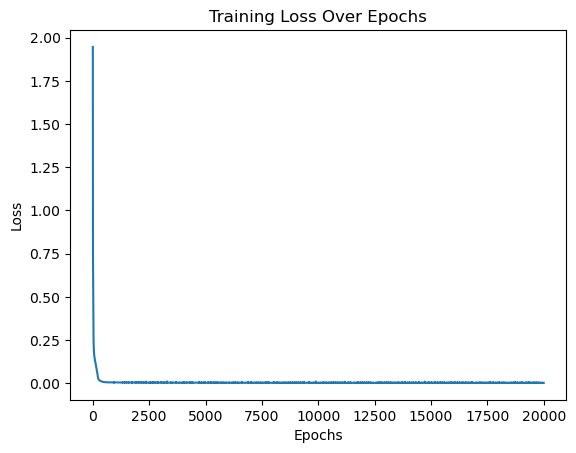

In [29]:
epochs = 20000
loss_values = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(train_data.x, train_data.edge_index)
    loss = loss_fn(output, train_data.y)
    loss.backward()
    optimizer.step()
    
    loss_values.append(loss.item())
    if epoch % 2000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

if len(loss_values) > 0:  # Ensure that loss values are available
    plt.plot(range(len(loss_values)), loss_values)  # Use the actual length of loss_values
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()
else:
    print("No loss values to plot. Check the training loop for issues.") 

RMSE: 0.0948


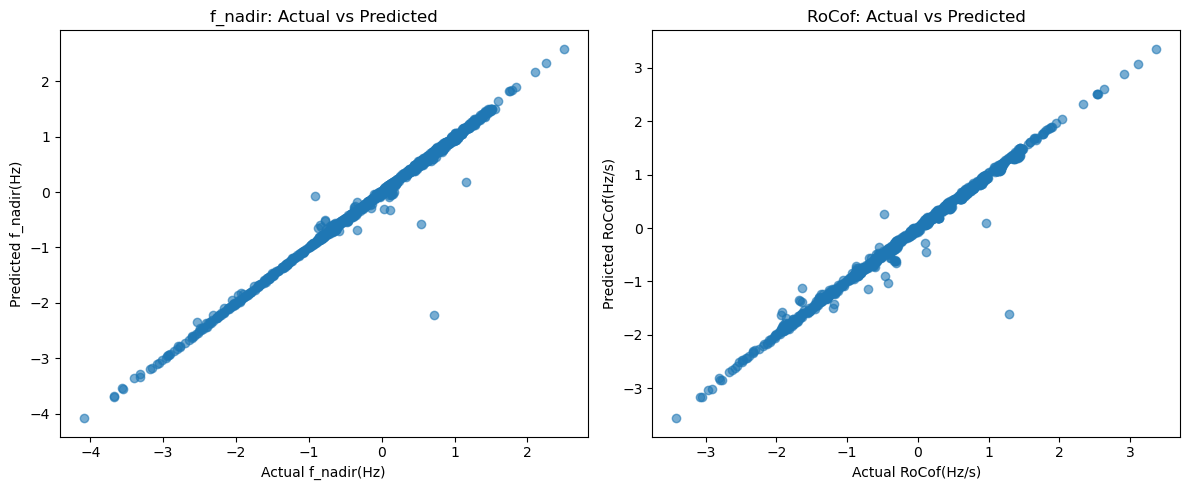

In [30]:
model.eval()
with torch.no_grad():
    predictions = model(test_data.x, test_data.edge_index).cpu().numpy()
    actual = test_data.y.cpu().numpy()

# Optionally inverse transform predictions if you scaled y
# predictions = scaler_y.inverse_transform(predictions)
# actual = scaler_y.inverse_transform(actual)

rmse = np.sqrt(np.mean((predictions - actual)**2))
print(f"RMSE: {rmse:.4f}")

# Plot predicted vs actual for f_nadir and RoCof
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(actual[:, 0], predictions[:, 0], alpha=0.6)
plt.xlabel("Actual f_nadir(Hz)")
plt.ylabel("Predicted f_nadir(Hz)")
plt.title("f_nadir: Actual vs Predicted")

plt.subplot(1, 2, 2)
plt.scatter(actual[:, 1], predictions[:, 1], alpha=0.6)
plt.xlabel("Actual RoCof(Hz/s)")
plt.ylabel("Predicted RoCof(Hz/s)")
plt.title("RoCof: Actual vs Predicted")

plt.tight_layout()
plt.show()
